<a href="https://colab.research.google.com/github/suyeonlee333333/oss2025/blob/main/%EB%AC%B8%ED%94%84_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%B5%9C%EC%A2%85_%EC%BD%94%EB%93%9C_(%EB%AC%B4%EC%9E%84_%EC%86%90%EC%8B%A4%EC%95%A1_%EC%98%88%EC%B8%A1)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[0] 공통: 파일 불러오기 및 데이터 전처리 셀

In [ ]:
# 📁 [0] 데이터 불러오기 및 병합
import pandas as pd

# 엑셀 파일 경로 (Colab에 업로드했다면 드라이브 경로나 마운트 필요)
file_path = "무임인원 데이터 수정본.xlsx"

# 시트 불러오기
df_train = pd.read_excel(file_path, sheet_name="학습시킬 데이터")
df_population = pd.read_excel(file_path, sheet_name="월별 인구 수")

# 날짜 포맷 정리 및 병합
df_train["연도-월"] = pd.to_datetime(df_train["연도-월"])
df_population["월간 / 나이"] = pd.to_datetime(df_population["월간 / 나이"])
df_population.rename(columns={"월간 / 나이": "연도-월"}, inplace=True)

df_merged = pd.merge(df_train, df_population, on="연도-월", how="inner")
print(df_merged.head())

# 조정 고령 인구수 계산 함수
def calculate_adjusted_elderly_fixed(df, age_threshold):      #예를 들어 67세 이상 고령자 수를 구하고 싶으면 ?  df_merged = calculate_adjusted_elderly_fixed(df_merged, 67)
    age_cols = []                                          #그러면 기존의 데이터프레임에 '조정 고령 인구수'라는 항목이 새로 생겨서 65세 이상의 총 고령자 수가 적힘.
    age_cols = []
    for col in df.columns:
        if isinstance(col, int) and col >= age_threshold:
            age_cols.append(col)
    df["조정 고령 인구수"] = df[age_cols].sum(axis=1)
    return df

        연도-월   지하철 이용량  기준연령  총 고령 인구수     무임인원    무임인원비율  무임손실액 (백만)       총  \
0 2021-01-01  17834292    65    649577  5419112  0.303859   7586.7568  649577   
1 2021-02-01  18431141    65    652254  5505261  0.298693   7707.3654  652254   
2 2021-03-01  23348552    65    655874  7028495  0.301025   9839.8930  655874   
3 2021-04-01  22250031    65    658150  6783118  0.304859   9496.3652  658150   
4 2021-05-01  22606497    65    660561  6864538  0.303653   9610.3532  660561   

      65     66  ...    91    92    93    94   95   96   97   98   99  100  
0  56794  49126  ...  2949  2450  1808  1079  831  539  442  343  193  315  
1  55663  50668  ...  3009  2415  1872  1135  812  563  439  338  209  317  
2  53803  53428  ...  3020  2425  1903  1157  857  556  434  333  213  330  
3  53426  54362  ...  2958  2476  1898  1174  860  573  422  344  214  332  
4  53112  54743  ...  2898  2524  1929  1212  837  587  409  351  228  337  

[5 rows x 44 columns]


데이터 분석을 위한 시각화 자료(참고용)

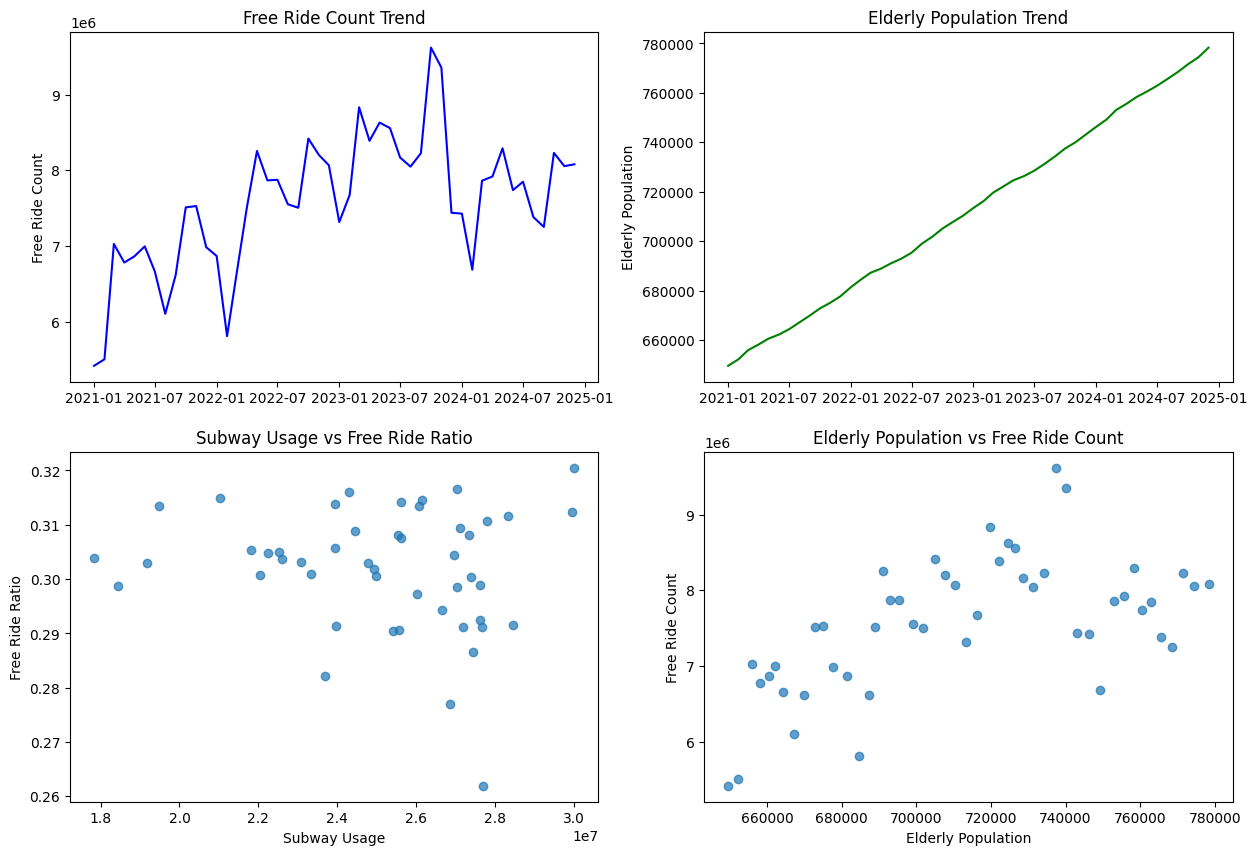

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

def analyze_data_patterns(df):

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # [1] 무임승차 인원 추이
    axes[0,0].plot(df['연도-월'], df['무임인원'], color='blue')
    axes[0,0].set_title('Free Ride Count Trend')  #'무임승차 인원 추이'
    axes[0,0].set_ylabel('Free Ride Count')       #'무임인원'

    # [2] 고령 인구수 추이
    axes[0,1].plot(df['연도-월'], df['총 고령 인구수'], color='green')
    axes[0,1].set_title('Elderly Population Trend')     #'총 고령 인구수 추이'
    axes[0,1].set_ylabel('Elderly Population')          #'총 고령 인구수'

    # [3] 지하철 이용량 vs 무임승차 비율
    axes[1,0].scatter(df['지하철 이용량'], df['무임인원비율'], alpha=0.7)
    axes[1,0].set_title('Subway Usage vs Free Ride Ratio')  # '지하철 이용량 vs 무임인원 비율'
    axes[1,0].set_xlabel('Subway Usage')                    # '지하철 이용량'
    axes[1,0].set_ylabel('Free Ride Ratio')                 # '무임인원비율'

    # [4] 총 고령 인구수 vs 무임승차 인원
    axes[1,1].scatter(df['총 고령 인구수'], df['무임인원'], alpha=0.7)
    axes[1,1].set_title('Elderly Population vs Free Ride Count')  # '총 고령 인구수 vs 무임승차 인원'
    axes[1,1].set_xlabel('Elderly Population')                    # '총 고령 인구수'
    axes[1,1].set_ylabel('Free Ride Count')                       # '무임인원'

    plt.show()

analyze_data_patterns(df_merged)

[1] Random Forest 단일 변수 모델 학습 및 정확도 분석

In [ ]:
# 🔍 [1] Random Forest 단일 변수 모델 학습 및 정확도 평가
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 기준연령 설정 및 입력값 준비
df_adjusted = calculate_adjusted_elderly_fixed(df_merged.copy(), age_threshold=65)  #지금은 무임승차 기준 나이가 65세이므로 // (조정 고령 인구수 = 총 고령 인구수)으로 학습하는 것과 다름없음.
X = df_adjusted[["조정 고령 인구수"]]   #학습 입력값 (독립변수)
y = df_adjusted["무임인원"]             #예측 목표값 (종속변수)

# 모델 학습
model_rf_single = RandomForestRegressor(n_estimators=100, random_state=42)  #100개의 트리 생성, 42열까지 시드고정(실험용 데이터)
model_rf_single.fit(X, y)   #모델을 학습시킴.  X(조정 고령 인구수) → y(무임인원)의 관계를 학습함.


# 예측 및 평가
y_pred = model_rf_single.predict(X)  #훈련 데이터에 대한 예측값 생성
mse = mean_squared_error(y, y_pred)  #예측값과 실제값의 오차를 제곱해 평균낸 값. 값이 작을수록 예측이 정밀하다는 뜻.
r2 = r2_score(y, y_pred)   #결정계수. 모델이 데이터를 얼마나 잘 설명하는지를 나타냄. 1에 가까울수록 설명력이 높음. (실제 데이터 전체와 예측 데이터 비교했을 때)

# 결과 출력
print("📊 [RandomForest 단일 변수 모델 정확도]")
print(f"평균 제곱 오차 (MSE): {mse:,.2f}")
print(f"결정계수 (R²): {r2:.4f}")

# 실제 vs 예측 비교 예시
# 실제 vs 예측 비교 예시 + 오차 포함
comparison_df = pd.DataFrame({
    "실제 무임인원": y,
    "예측 무임인원": y_pred.round(),
    "오차": (y_pred - y).round()  # 예측 - 실제
})

# 최근 10개 데이터 확인
print("\n📋 [실제 vs 예측 무임인원 비교 (최근 10개)]")
print(comparison_df.tail(10))


📊 [RandomForest 단일 변수 모델 정확도]
평균 제곱 오차 (MSE): 25,436,044,844.71
결정계수 (R²): 0.9670

📋 [실제 vs 예측 무임인원 비교 (최근 10개)]
    실제 무임인원    예측 무임인원        오차
38  7863625  7768370.0  -95256.0
39  7919144  7942087.0   22943.0
40  8291654  8103171.0 -188483.0
41  7739251  7868384.0  129133.0
42  7849707  7785807.0  -63900.0
43  7382329  7514862.0  132533.0
44  7253182  7367138.0  113956.0
45  8231007  8104604.0 -126403.0
46  8055973  8091676.0   35703.0
47  8080271  8078006.0   -2265.0


[2] 기준연령별 무임 손실액 시뮬레이션

In [ ]:
# 📈 [2] 기준연령별 무임 손실액 시뮬레이션 (단일 변수 RF 모델)
def simulate_rf_single_variable_loss(df_original, model, age_range=(65, 75)):
    results = []
    for age in range(age_range[0], age_range[1] + 1):
        df_temp = calculate_adjusted_elderly_fixed(df_original.copy(), age_threshold=age)
        X_temp = df_temp[["조정 고령 인구수"]]
        df_temp["예측 무임인원"] = model.predict(X_temp)

        # 평균 손실액 계산
        mean_loss_per_person = df_original["무임손실액 (백만)"].sum() / df_original["무임인원"].sum()
        df_temp["예측 손실액(백만)"] = df_temp["예측 무임인원"] * mean_loss_per_person

        results.append({
            "기준연령": age,
            "예측 무임인원 합계": int(df_temp["예측 무임인원"].sum()),
            "예측 손실액 합계(백만)": round(df_temp["예측 손실액(백만)"].sum(), 2)
        })

    df_result = pd.DataFrame(results)
    base_loss = df_result.loc[df_result["기준연령"] == age_range[0], "예측 손실액 합계(백만)"].values[0]
    df_result["손실액 절감액(백만)"] = df_result["예측 손실액 합계(백만)"].apply(lambda x: round(base_loss - x, 2))
    df_result["절감률(%)"] = df_result["손실액 절감액(백만)"] / base_loss * 100

    return df_result

# 시뮬레이션 실행
df_simulation = simulate_rf_single_variable_loss(df_merged, model_rf_single, age_range=(65, 75))
df_simulation


,기준연령,예측 무임인원 합계,예측 손실액 합계(백만),손실액 절감액(백만),절감률(%)
0,65,363708602,509192.04,0.00,0.000000
1,66,312803260,437924.56,71267.48,13.996189
2,67,276985420,387779.59,121412.45,23.844137
3,68,272099624,380939.47,128252.57,25.187466
4,69,272099624,380939.47,128252.57,25.187466
5,70,272099624,380939.47,128252.57,25.187466
6,71,272099624,380939.47,128252.57,25.187466
7,72,272099624,380939.47,128252.57,25.187466
8,73,272099624,380939.47,128252.57,25.187466
9,74,272099624,380939.47,128252.57,25.187466


이 뒤로는 위의 표를 시각화한거라 볼 필요 없음.(필요하면 PPT 자료?)

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47161 (\N{HANGUL SYLLABLE RYEONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG})

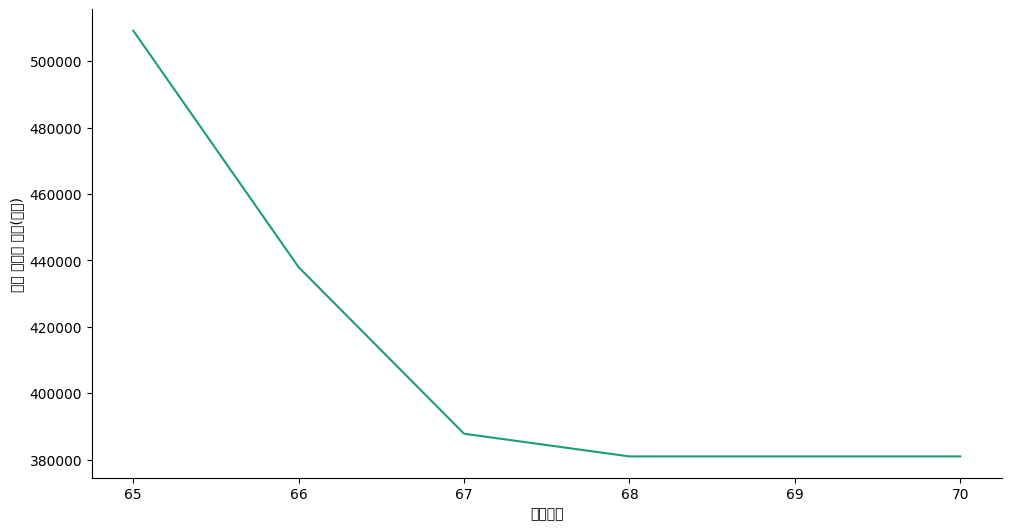

In [ ]:
# @title 기준연령 vs 예측 손실액 합계(백만)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['기준연령']
  ys = series['예측 손실액 합계(백만)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_simulation.sort_values('기준연령', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('기준연령')
_ = plt.ylabel('예측 손실액 합계(백만)')